In [2]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import scipy.stats as stats
from pathlib import Path

# Creating the db 

two separates db for senate and congress

In [ ]:
# Loop through congress files
for i in range(79, 81):
    
    "------ Loading files -------"
    
    year_str = f"{i:03}"
    base_dir_load = Path("../data/raw")

    speeches_file = base_dir_load / f"speeches/speeches_{year_str}.txt"
    map_file = base_dir_load / f"speaker_map/{year_str}_SpeakerMap.txt"
    metadata_file = base_dir_load /f"metadata/descr_{year_str}.txt"
    
    print("Processing:", speeches_file, map_file, metadata_file)
    df_speeches = pd.read_csv(speeches_file, sep="|", encoding="latin1", dtype={"speech_id": str}, on_bad_lines="skip", engine="python")
    df_map = pd.read_csv(map_file, encoding='windows-1252', delimiter="|")
    df_metadata = pd.read_csv(metadata_file, encoding='windows-1252', delimiter="|")

    # converts type
    df_speeches["speech_id"] = pd.to_numeric(df_speeches["speech_id"], errors="coerce").astype("Int64")
    df_map.chamber = pd.Categorical(df_map.chamber)
    df_map.party = pd.Categorical(df_map.party)
    
    "------ Dropping column -------"
    
    # Clean speaker map
    df_map = df_map.drop(["district", "nonvoting", "state", "gender"], axis=1)
    # Clean metadata
    df_metadata = df_metadata[['speech_id', 'date', 'char_count', 'word_count']]

    "------ Merging -------"
    
    df_merge1 = pd.merge(df_speeches, df_map, on="speech_id", how="outer")
    df_merged = pd.merge(df_merge1, df_metadata, on="speech_id", how="outer")
    
    #checking speaker_id when is na
    """ rows_with_speakerid_na = df_merged[df_merged['speakerid'].isna()]
    rows_with_party_na = df_merged[df_merged['party'].isna()]
    print(rows_with_speakerid_na.head())
    print(rows_with_speakerid_na.shape) """

    df_merged = df_merged.dropna(subset=["speakerid"])
    df_merged['speakerid'] = df_merged['speakerid'].astype(int)
    df_merged = df_merged[df_merged['party'].isin(['D', 'R'])]
    df_merged['party'] = df_merged['party'].cat.remove_unused_categories()
    
    #rename date to year
    df_merged['date'] = df_merged['date'].astype(str).str[:4].astype(int)
    df_merged.rename(columns={'date': 'year'}, inplace=True)
    
    # Save chamber-specific dataframes
    df_senate = df_merged[df_merged['chamber'] == 'S'].copy()
    df_house = df_merged[df_merged['chamber'] == 'H'].copy()
    
    #print(df_house.head())

    "------ Saving to csv -------"
    # Define relative base directory
    base_dir = Path("../data/merged")

    # Construct full file paths
    filepath_senate = base_dir / f"senate_db/senate_merged_{year_str}.csv"
    filepath_house = base_dir / f"house_db/house_merged_{year_str}.csv"

    # Create the folder if it doesn't exist
    base_dir.mkdir(parents=True, exist_ok=True)

    # Save to CSV
    df_senate.to_csv(filepath_senate, index=False)
    df_house.to_csv(filepath_house, index=False)


Processing: ..\data\raw\speeches\speeches_079.txt ..\data\raw\speaker_map\079_SpeakerMap.txt ..\data\raw\metadata\descr_079.txt
Processing: ..\data\raw\speeches\speeches_080.txt ..\data\raw\speaker_map\080_SpeakerMap.txt ..\data\raw\metadata\descr_080.txt


# Fetching stats

### House of Representative stats

In [ ]:
house_result_frames = []

for i in range(79, 112):
    
    "------ Loading files -------"
    
    print(f'── Processing Congress {i} ──')
    year_str = f"{i:03}"
    base_dir = Path("../data/merged")
    house_file = base_dir / f"house_db/house_merged_{year_str}.csv"
    df = pd.read_csv(house_file)
    
    "------ Grouping  -------"
    
    #grouping by party and counting speaker and speech
    house_party_year_stats = (
        df.groupby(['year', 'party'])
        .agg(num_speeches=('speech_id',  'count'),
            num_speakers=('speakerid',  'nunique'),
            mean_words   =('word_count','mean'))     
        .rename(index={'R':'Republican', 'D':'Democrat'})
        .sort_index()
    )
    
    #adding proportion to the table
    
    #Find the per‑year denominator for each metric
    year_totals = house_party_year_stats.groupby(level='year').transform('sum')
    #Add percentage columns (×100 for a friendlier reading)
    house_party_year_stats['pct_speeches'] = (
        house_party_year_stats['num_speeches'] / year_totals['num_speeches'] * 100
    )
    house_party_year_stats['pct_speakers'] = (
        house_party_year_stats['num_speakers'] / year_totals['num_speakers'] * 100
    )
    #Order of columns
    house_party_year_stats = house_party_year_stats[
        ['num_speeches', 'pct_speeches', 'num_speakers', 'pct_speakers', "mean_words"]
    ]
    
    #dropping the third year. < 1000 speech trash
    yr_totals = house_party_year_stats.groupby(level='year')['num_speeches'].sum()
    years_to_drop = yr_totals[yr_totals < 1000].index   # Index of bad years
    if len(years_to_drop):
        house_party_year_stats = house_party_year_stats.drop(years_to_drop, level='year')
        print(f"removed tiny-overlap year(s): {list(years_to_drop)}")

    house_result_frames.append(house_party_year_stats.reset_index())
    
    #print(house_party_year_stats.round(1))

── Processing Congress 79 ──
                 num_speeches  pct_speeches  num_speakers  pct_speakers  \
year party                                                                
1945 Democrat           28783          51.1           232          55.2   
     Republican         27534          48.9           188          44.8   
1946 Democrat           24182          51.5           226          55.1   
     Republican         22756          48.5           184          44.9   

                 mean_words  
year party                   
1945 Democrat         100.7  
     Republican        98.9  
1946 Democrat          93.1  
     Republican        92.3  
── Processing Congress 80 ──
                 num_speeches  pct_speeches  num_speakers  pct_speakers  \
year party                                                                
1947 Democrat           15116          35.8           183          43.7   
     Republican         27150          64.2           236          56.3   
1948 Democr

### Senate stats

In [ ]:
senate_result_frames = []

for i in range(79, 112):
    
    "------ Loading files -------"
    
    print(f'── Processing Congress {i} ──')
    year_str = f"{i:03}"
    base_dir = Path("../data/merged")
    senate_file = base_dir / f"senate_db/senate_merged_{year_str}.csv"
    
    print("Processing:", senate_file)
    df = pd.read_csv(senate_file)
    
    "------ Grouping  -------"
    
    #grouping by party and counting speaker and speech
    senate_party_year_stats = (
        df.groupby(['year', 'party'])
        .agg(num_speeches=('speech_id',  'count'),
            num_speakers=('speakerid',  'nunique'),
            mean_words   =('word_count','mean'))      
        .rename(index={'R':'Republican', 'D':'Democrat'})
        .sort_index()
    )
    
    #adding proportion to the table
    
    #Find the per‑year denominator for each metric
    year_totals = senate_party_year_stats.groupby(level='year').transform('sum')
    #Add percentage columns (×100 for a friendlier reading)
    senate_party_year_stats['pct_speeches'] = (
        senate_party_year_stats['num_speeches'] / year_totals['num_speeches'] * 100
    )
    senate_party_year_stats['pct_speakers'] = (
        senate_party_year_stats['num_speakers'] / year_totals['num_speakers'] * 100
    )
    #Order of columns
    senate_party_year_stats = senate_party_year_stats[
        ['num_speeches', 'pct_speeches', 'num_speakers', 'pct_speakers', "mean_words"]
    ]
    
    #dropping the third year. < 1000 speech trash
    yr_totals = senate_party_year_stats.groupby(level='year')['num_speeches'].sum()
    years_to_drop = yr_totals[yr_totals < 1000].index   # Index of bad years
    if len(years_to_drop):
        senate_party_year_stats = senate_party_year_stats.drop(years_to_drop, level='year')
        print(f"removed tiny-overlap year(s): {list(years_to_drop)}")

    
    senate_result_frames.append(senate_party_year_stats.reset_index())

    #print(senate_party_year_stats.round(1))

── Processing Congress 79 ──
Processing: ..\data\processed\senate_db\senate_merged_079.csv
                 num_speeches  pct_speeches  num_speakers  pct_speakers  \
year party                                                                
1945 Democrat           32633          61.2            58          57.4   
     Republican         20690          38.8            43          42.6   
1946 Democrat           32177          60.3            57          58.8   
     Republican         21165          39.7            40          41.2   

                 mean_words  
year party                   
1945 Democrat          86.4  
     Republican       101.9  
1946 Democrat          87.7  
     Republican        94.9  
── Processing Congress 80 ──
Processing: ..\data\processed\senate_db\senate_merged_080.csv
                 num_speeches  pct_speeches  num_speakers  pct_speakers  \
year party                                                                
1947 Democrat           22499        

# Graph stats

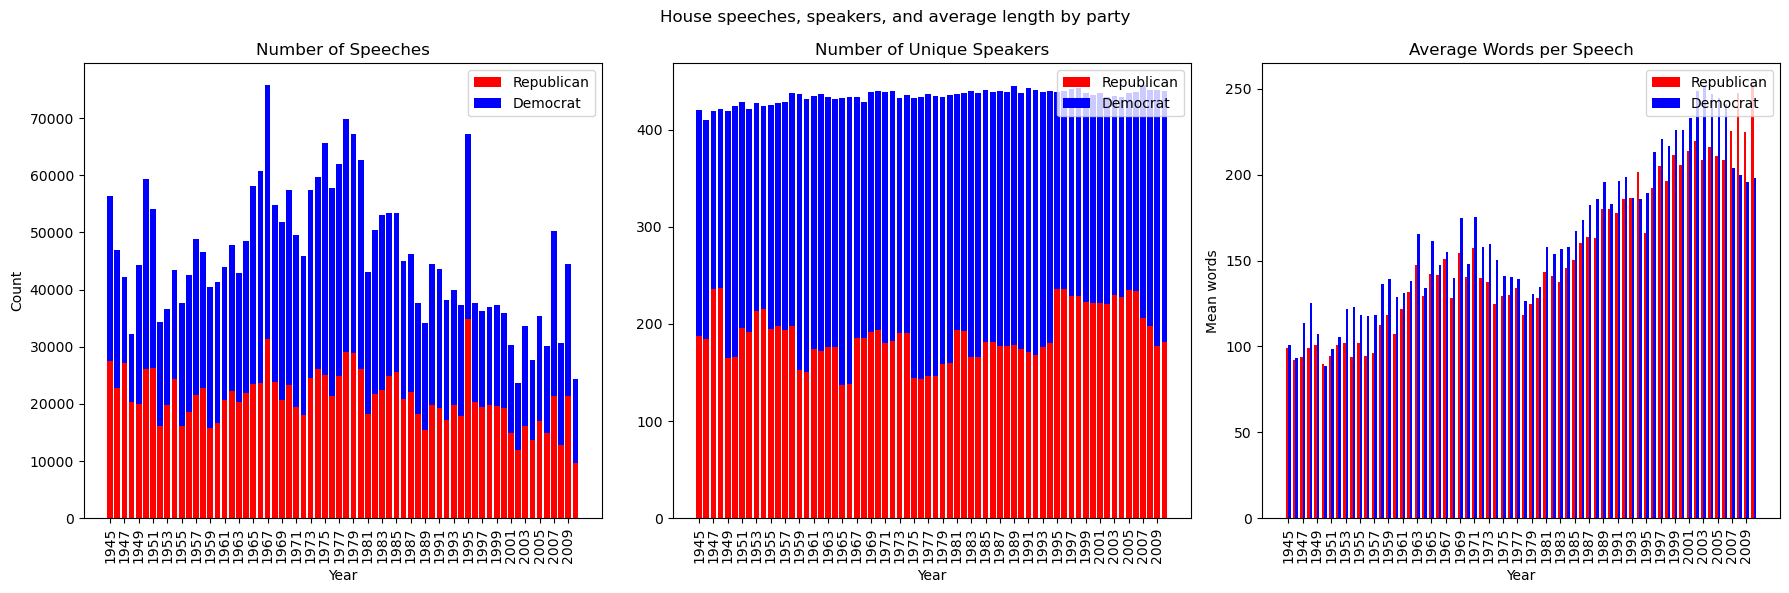

In [7]:
# ---------- collect the tables built in Cell 1 ----------
all_stats = pd.concat(house_result_frames, ignore_index=True)


agg = (
    all_stats
    .groupby(['year', 'party'], as_index=False)
    .agg(num_speeches=('num_speeches', 'sum'),
        num_speakers=('num_speakers', 'sum'),
        mean_words  =('mean_words',  'mean'))
)

# wide tables
speech_pct   = all_stats.pivot(index='year', columns='party', values='pct_speeches').fillna(0)
speaker_pct  = all_stats.pivot(index='year', columns='party', values='pct_speakers').fillna(0)
speech_vals  = agg.pivot(index='year', columns='party', values='num_speeches').fillna(0)
speaker_vals = agg.pivot(index='year', columns='party', values='num_speakers').fillna(0)
mean_words   = agg.pivot(index='year', columns='party', values='mean_words').fillna(0)


# make sure both parties are present
for p in ['Republican', 'Democrat']:
    for tbl in [speech_vals, speaker_vals, speech_pct, speaker_pct, mean_words]:
        if p not in tbl.columns:
            tbl[p] = 0

years = speech_vals.index.astype(str)
x     = np.arange(len(years))          # numeric x‑positions

# assume speech_vals, speaker_vals, mean_words are already built
years = speech_vals.index.astype(str)
x     = np.arange(len(years))

rs, ds = speech_vals['Republican'],  speech_vals['Democrat']
ru, du = speaker_vals['Republican'], speaker_vals['Democrat']
rw, dw = mean_words['Republican'],   mean_words['Democrat']

fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharex=True)

# A ‒ speeches
axes[0].bar(x, rs, color='red',  label='Republican')
axes[0].bar(x, ds, bottom=rs, color='blue', label='Democrat')
axes[0].set_title('Number of Speeches')
axes[0].set_ylabel('Count')

# B ‒ speakers
axes[1].bar(x, ru, color='red',  label='Republican')
axes[1].bar(x, du, bottom=ru, color='blue', label='Democrat')
axes[1].set_title('Number of Unique Speakers')

# C ‒ mean words (side‑by‑side)
bar_w = 0.35
axes[2].bar(x - bar_w/2, rw, width=bar_w, color='red',  label='Republican')
axes[2].bar(x + bar_w/2, dw, width=bar_w, color='blue', label='Democrat')
axes[2].set_title('Average Words per Speech')
axes[2].set_ylabel('Mean words')

# -------------- show only every 2nd year -----------------------------
tick_pos   = x[::2]      # 0, 2, 4, …
tick_labels = years[::2]

for ax in axes:
    ax.set_xticks(tick_pos)
    ax.set_xticklabels(tick_labels, rotation=90)
    ax.set_xlabel('Year')
    ax.legend(loc='upper right')

fig.suptitle('House speeches, speakers, and average length by party')
plt.tight_layout()
plt.show()


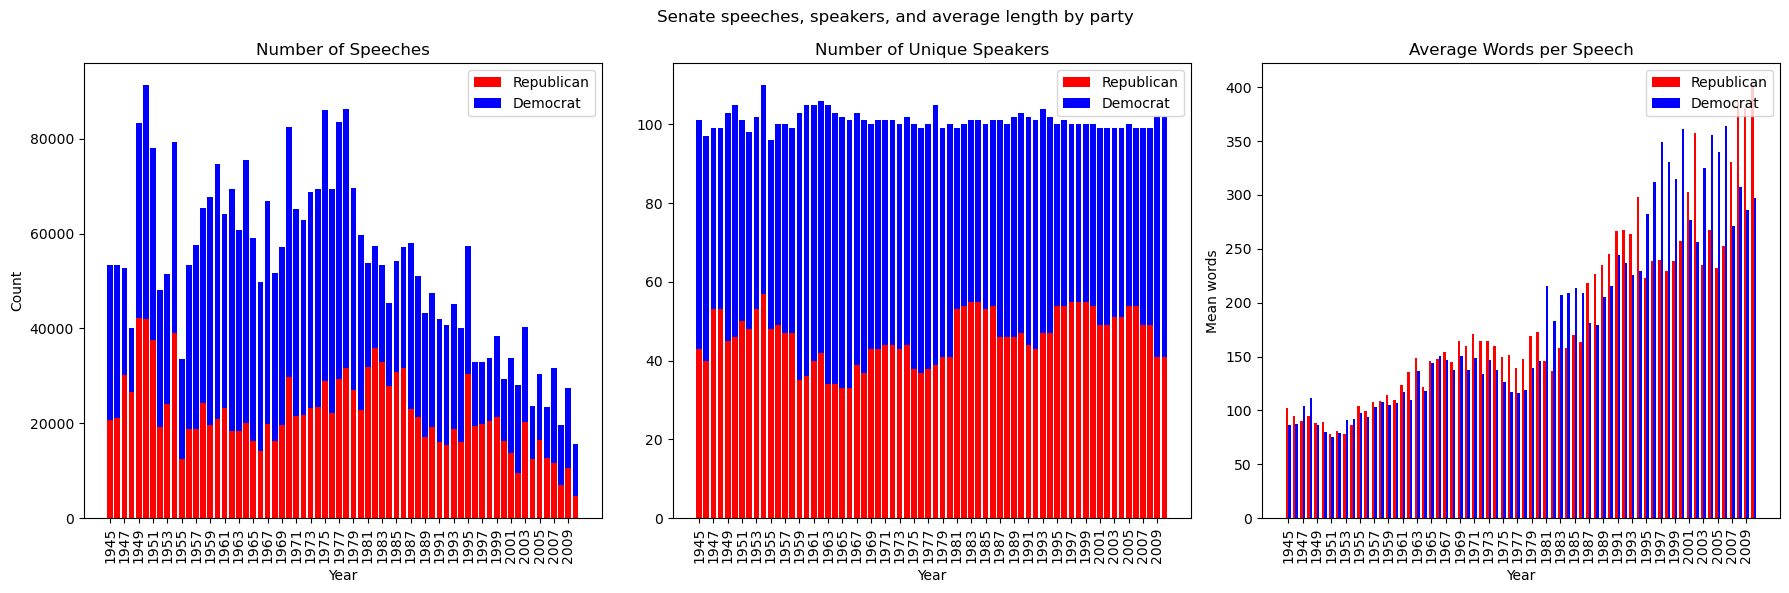

In [8]:
# ---------- collect the tables built in Cell 1 ----------
all_stats = pd.concat(senate_result_frames, ignore_index=True)


agg = (
    all_stats
    .groupby(['year', 'party'], as_index=False)
    .agg(num_speeches=('num_speeches', 'sum'),
        num_speakers=('num_speakers', 'sum'),
        mean_words  =('mean_words',  'mean'))
)

# wide tables
speech_pct   = all_stats.pivot(index='year', columns='party', values='pct_speeches').fillna(0)
speaker_pct  = all_stats.pivot(index='year', columns='party', values='pct_speakers').fillna(0)
speech_vals  = agg.pivot(index='year', columns='party', values='num_speeches').fillna(0)
speaker_vals = agg.pivot(index='year', columns='party', values='num_speakers').fillna(0)
mean_words   = agg.pivot(index='year', columns='party', values='mean_words').fillna(0)


# make sure both parties are present
for p in ['Republican', 'Democrat']:
    for tbl in [speech_vals, speaker_vals, speech_pct, speaker_pct, mean_words]:
        if p not in tbl.columns:
            tbl[p] = 0

years = speech_vals.index.astype(str)
x     = np.arange(len(years))          # numeric x‑positions

# assume speech_vals, speaker_vals, mean_words are already built
years = speech_vals.index.astype(str)
x     = np.arange(len(years))

rs, ds = speech_vals['Republican'],  speech_vals['Democrat']
ru, du = speaker_vals['Republican'], speaker_vals['Democrat']
rw, dw = mean_words['Republican'],   mean_words['Democrat']

fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharex=True)

# A ‒ speeches
axes[0].bar(x, rs, color='red',  label='Republican')
axes[0].bar(x, ds, bottom=rs, color='blue', label='Democrat')
axes[0].set_title('Number of Speeches')
axes[0].set_ylabel('Count')

# B ‒ speakers
axes[1].bar(x, ru, color='red',  label='Republican')
axes[1].bar(x, du, bottom=ru, color='blue', label='Democrat')
axes[1].set_title('Number of Unique Speakers')

# C ‒ mean words (side‑by‑side)
bar_w = 0.35
axes[2].bar(x - bar_w/2, rw, width=bar_w, color='red',  label='Republican')
axes[2].bar(x + bar_w/2, dw, width=bar_w, color='blue', label='Democrat')
axes[2].set_title('Average Words per Speech')
axes[2].set_ylabel('Mean words')

# -------------- show only every 2nd year -----------------------------
tick_pos   = x[::2]      # 0, 2, 4, …
tick_labels = years[::2]

for ax in axes:
    ax.set_xticks(tick_pos)
    ax.set_xticklabels(tick_labels, rotation=90)
    ax.set_xlabel('Year')
    ax.legend(loc='upper right')

fig.suptitle('Senate speeches, speakers, and average length by party')
plt.tight_layout()
plt.show()
